# Localization of Findings

In this competition, the goal is to examine a chest x-ray image and plot a bounding box around findings of significance, along with a confidence rating. There are 13 classes that are of clinical significance with bounding boxes that span more than a single pixel in the chest x-ray. There is one class (`No finding`) that means that no signficiant finding was observed that has a bounding box that spans a single pixel. 

There are many approaches to solving this problem, however, I believe the first step is to determine what the bounding box information actually looks like for each class. In particular, the purpose of this notebook is to see if bounding boxes for various target classes can be partially localized to one or more non-random areas on the chest x-ray. In this notebook we will:

* Load the training data and augment it with information available from the dicom files.
* Extract bounding box information for each class and overlay each on a heatmap that approximates the dimensions of a chest x-ray.
* Examine patterns for each class of clinical finding.

The hope with this exercise is that we can reveal patterns as to where various clinical findings are likely to be found on a chest x-ray. We may be able to use these localizations to build classifiers that target those areas only, instead of concentrating on the x-ray image as a whole.

# 1. Reading and Augmenting Training Data

In this section, we will read in the training data, and then augment it with image meta-data from the associated dicom files. First, let's load up the training CSV file as we normally would.

In [6]:
!ls /home/data

sample_submission.csv  test  train  train.csv


In [7]:
import pandas as pd
from sklearn.cluster import KMeans

train_aug = pd.read_csv('/home/data/train.csv')
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


Our next step is to pull in some basic information about each dicom file. In particular, what we're interested in is the height and width of the image. This gives us context for our bounding boxes. We'll use `pydicom` to read the image file and add some useful information to our training data. Let's leave out anything related to `class_id` 14, which is our `No finding` class. This will make loading meta-data faster since we don't have to load files for classes with no bounding boxes.

In [8]:
from pathlib import Path
from pydicom import dcmread

def add_image_dimensions_gender(df):
    path_spec = "/home/data/train/{}.dicom"
    height = []
    width = []
    gender = []
    age = []
    for _, row in df.iterrows():
        dcm = dcmread(Path(path_spec.format(row["image_id"])), stop_before_pixels=True)
        height.append(dcm.Rows)
        width.append(dcm.Columns)
        gender.append(dcm[0x10, 0x40].value)
        patient_age = dcm[0x10, 0x1010].value if [0x10, 0x1010] in dcm else ""
        age.append(patient_age)
    df["image_height"] = height
    df["image_width"] = width
    df["gender"] = gender
    df["age"] = age

add_image_dimensions_gender(train_aug)
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_height,image_width,gender,age
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,M,
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,,
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,F,061Y
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,F,
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,3072,2540,F,022Y
...,...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,3200,2444,,
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,2430,1994,O,
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2500,2048,O,
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,2040,1968,F,052Y


# 2. Normalize Bounding Box Values

Now that we have width and height information, we have context for the bounding box information we find in the rest of the training dataset. Our next step is to normalize the location of the bounding boxes. Why? Because each image may be a different size. We want to know relatively speaking where each bounding box appears in an idealized chest x-ray image.

In [9]:
def scale_bounding_boxes(df):
    df["x_min_norm"] = df["x_min"] / df["image_width"]
    df["y_min_norm"] = df["y_min"] / df["image_height"]
    df["x_max_norm"] = df["x_max"] / df["image_width"]
    df["y_max_norm"] = df["y_max"] / df["image_height"]
    
scale_bounding_boxes(train_aug)
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_height,image_width,gender,age,x_min_norm,y_min_norm,x_max_norm,y_max_norm
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,M,,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,,,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,F,061Y,0.332212,0.588613,0.794712,0.783818
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,F,,0.548611,0.257986,0.699219,0.353819
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,3072,2540,F,022Y,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,3200,2444,,,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,2430,1994,O,,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2500,2048,O,,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,2040,1968,F,052Y,0.391768,0.479902,0.853659,0.642647


# 3. Density Heatmaps

Now we can create a density heatmap for each class of findings. We'll make our heatmap size have an aspect ratio of 4:5, which matches what we would expect on a chest x-ray image. This will help us localize where we expect to see each class of finding.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def draw_box_on_array(row, np_array):
    xy = [
        int(row["x_min_norm"] * 400), 
        int(row["y_min_norm"] * 500),
        int(row["x_max_norm"] * 400),
        int(row["y_max_norm"] * 500),
    ]
    np_array[xy[1]:xy[3], xy[0]:xy[2]] += 1
    
def get_bbox(df, class_id):
    np_array = np.zeros(shape=(500, 400))
    if class_id == 14:
        return np_array
    for _, row in df[df["class_id"] == class_id].iterrows():
        draw_box_on_array(row, np_array)
    return np_array

Now let's loop through each class of finding and generate a heatmap.

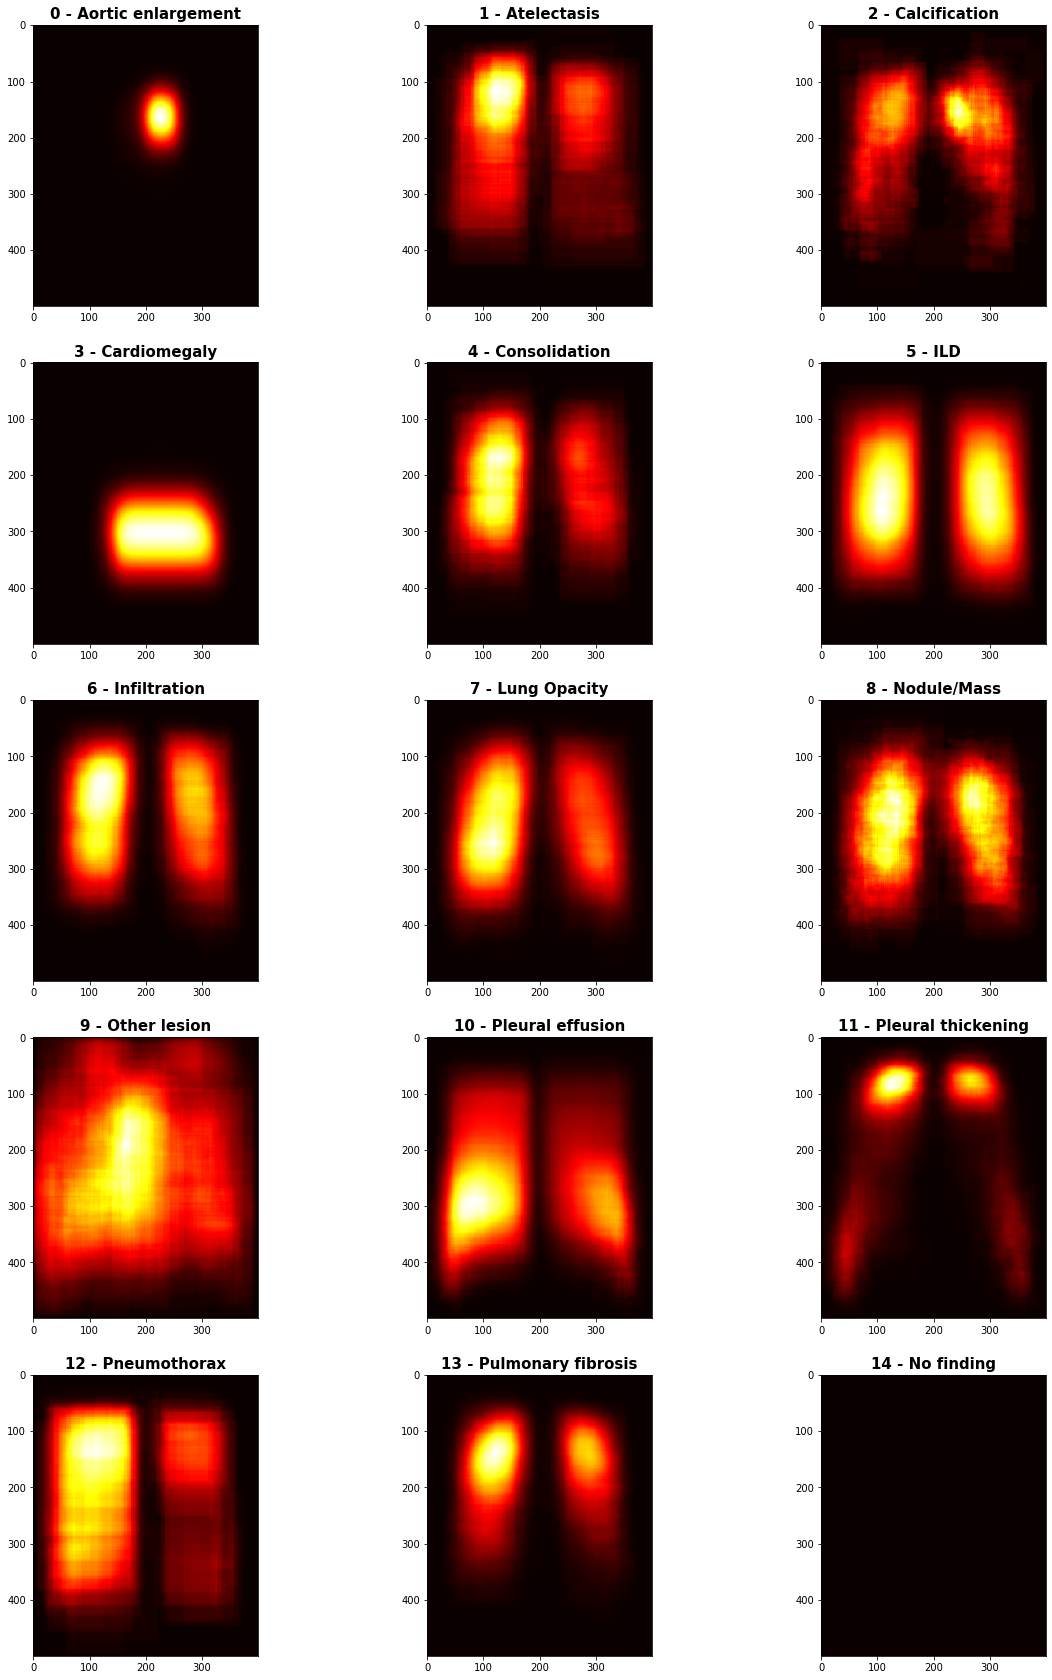

In [11]:
classes = [
    "0 - Aortic enlargement",
    "1 - Atelectasis",
    "2 - Calcification",
    "3 - Cardiomegaly", 
    "4 - Consolidation",
    "5 - ILD",
    "6 - Infiltration",
    "7 - Lung Opacity",
    "8 - Nodule/Mass",
    "9 - Other lesion",
    "10 - Pleural effusion",
    "11 - Pleural thickening",
    "12 - Pneumothorax",
    "13 - Pulmonary fibrosis",
    "14 - No finding",
]

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(get_bbox(train_aug, i), cmap='hot', interpolation='nearest')
    _ = ax.set_title(classes[i], fontweight="bold", size=15)

# 3.1 Localization by Gender

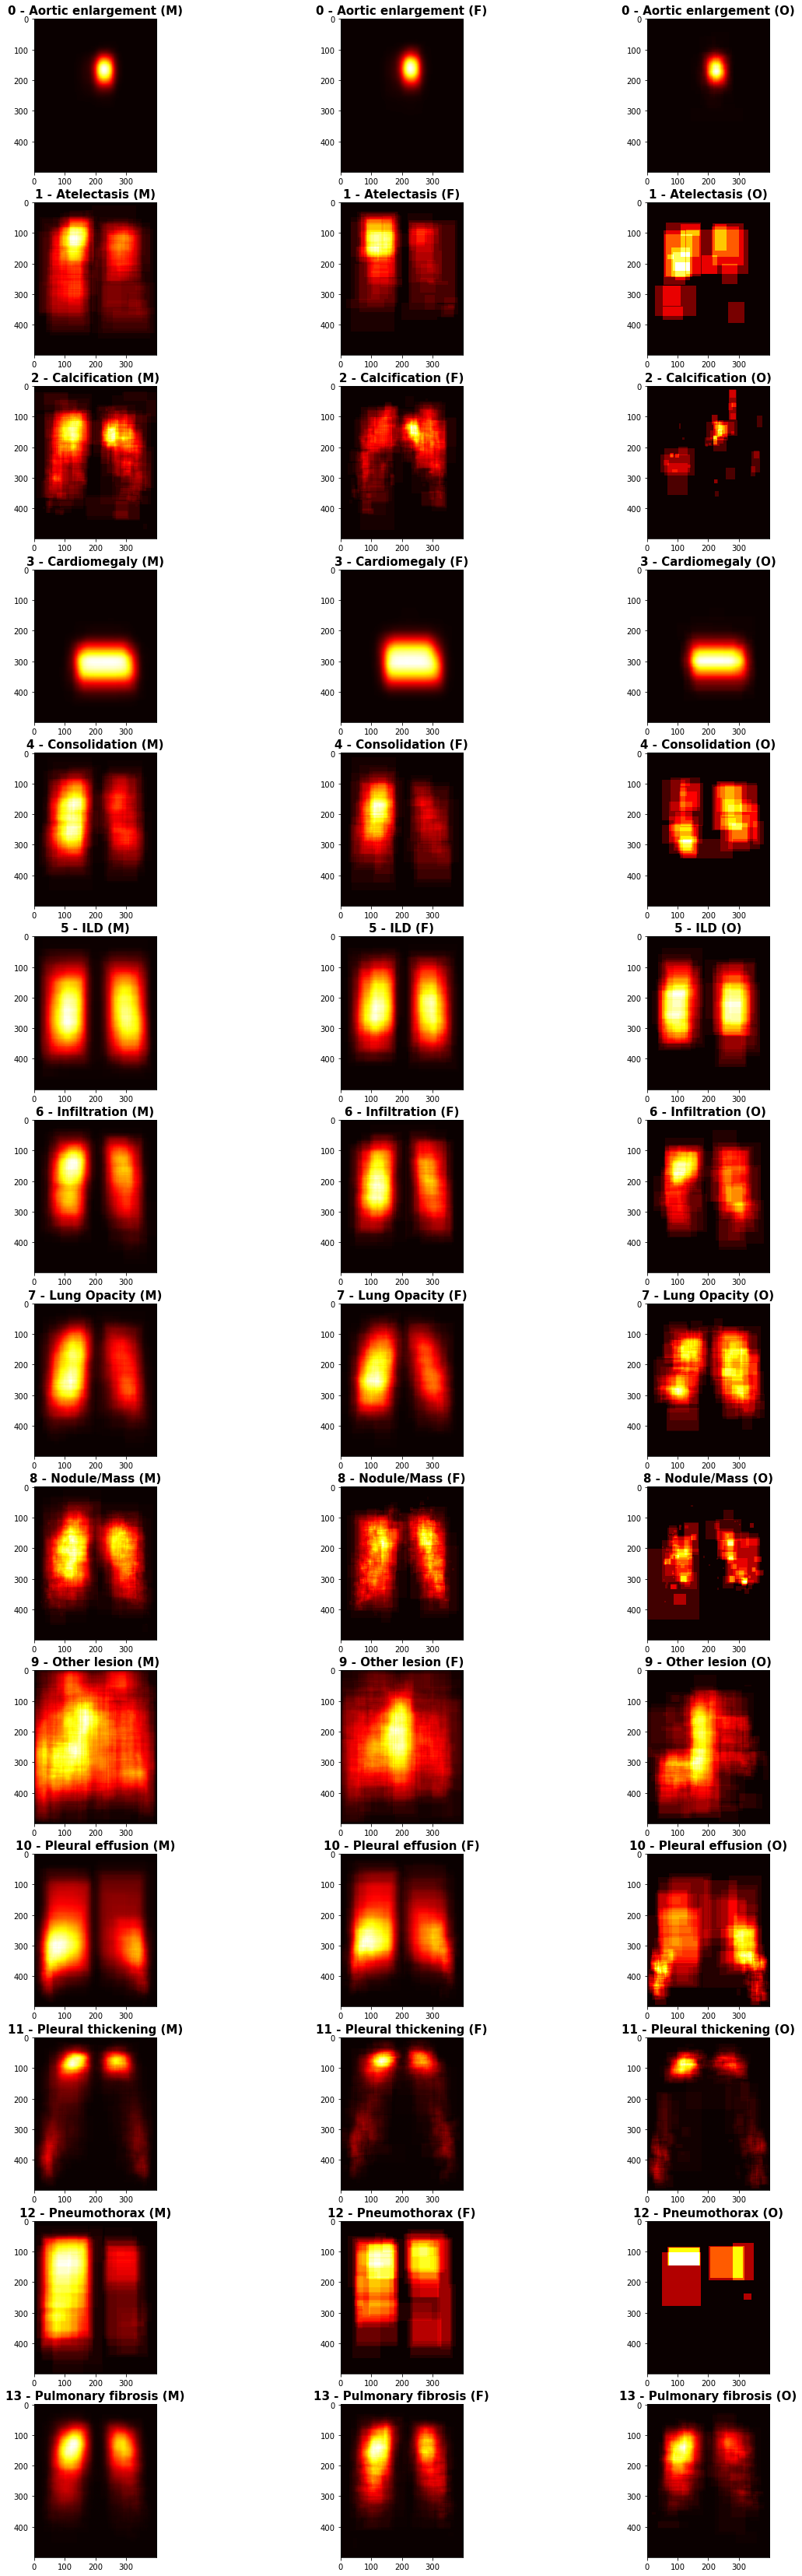

In [6]:
fig, axs = plt.subplots(nrows=14, ncols=3, figsize=(20, 60))

bboxes = [
    get_bbox(train_aug[(train_aug["gender"] == gender)], i)
    for i in range(14)
    for gender in ["M", "F", "O"]
]

names = [
    "{} ({})".format(classes[i], gender) 
    for i in range(14) 
    for gender in ["M", "F", "O"]
]

for i, (name, bbox, ax) in enumerate(zip(names, bboxes, axs.flatten())):
    ax.imshow(bbox, cmap='hot', interpolation='nearest')
    _ = ax.set_title(name, fontweight="bold", size=15)

# 3.3 Per Class Exploration

We should take a closer look at some of the classes to see where their bounding boxes originate, and see if there are any outliers. A simple way of looking for outliers is to take the center point of the bounding box and see how many standard deviations away from the mean it falls. This will give us a sense of how many exceptional points we have to deal with when trying to fit our model.

In [13]:
import seaborn as sns

from scipy.spatial import distance
from scipy import stats

def calculate_centers(df):
    x_centers = []
    y_centers = []
    for _, row in df.iterrows():
        x_center = (row["x_min_norm"] + ((row["x_max_norm"] - row["x_min_norm"]) / 2)) * 400
        y_center = (row["y_min_norm"] + ((row["y_max_norm"] - row["y_min_norm"]) / 2)) * 500
        x_centers.append(x_center)
        y_centers.append(y_center)
    df["x_center"] = x_centers
    df["y_center"] = y_centers

def get_probability_descriptor(x):
    if x < 2.0:
        return "95% probability"
    if x >= 2.0 and x < 3.0:
        return "5% probability"
    if x >= 3.0 and x < 4.0:
        return "1% probability"
    return "< 1% probability"

def calculate_distances_to_center(df):
    x_mean = df["x_center"].mean()
    y_mean = df["y_center"].mean()
    distances = []
    for _, row in df.iterrows():
        distances.append(distance.euclidean((row["x_center"], row["y_center"]), (x_mean, y_mean)))
    df["distances"] = distances
    df["std_dev_distances"] = np.abs(stats.zscore(df["distances"]))
    df["Probability Grouping"] = df["std_dev_distances"].apply(lambda x: get_probability_descriptor(x))

## 3.3.0 Aortic Enlargement

Below we're plotting the density heatmap on the left with the bounding box centers on the right. The Probability Grouping describes how many standard deviations from the mean each bounding box center occurs. As we can see, outliers colored in both green and red represent bounding box centers that are extremely rare events. These bounding box centers (particularly the red ones) will be difficult to generalize in any model, as they exist very far away from the majority of our training examples.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


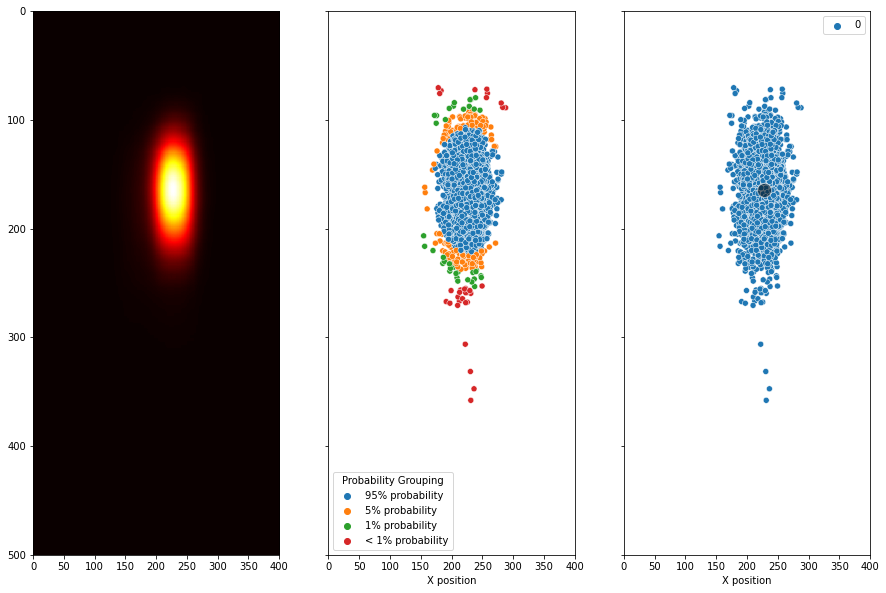

In [14]:
n_clusters = 1
class_id = 0

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == class_id)])
calculate_centers(coi)
calculate_distances_to_center(coi)

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(coi[["x_center", "y_center"]])
centroids = kmeans.predict(coi[["x_center", "y_center"]])
centers = kmeans.cluster_centers_

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)

axs[0].imshow(get_bbox(train_aug, 0), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=centroids, 
    ax=axs[2],
)
sns.scatterplot(
    centers[:, 0], centers[:, 1], c=['black'], s=200, alpha=0.5, ax=axs[2],
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.1 Atelectasis

Here we should consider both the left and right sides separately. This is because we may see variations between sides.

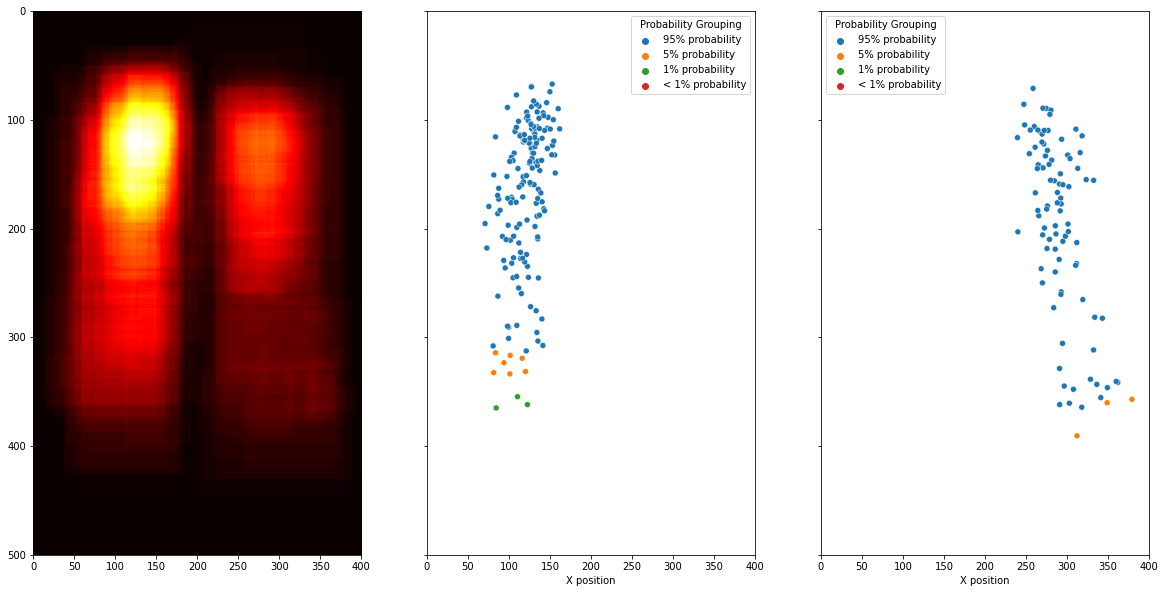

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 1) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 1), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 1) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.2 Calcification

Again, we have both the right and left side of the body to consider as separate entities.

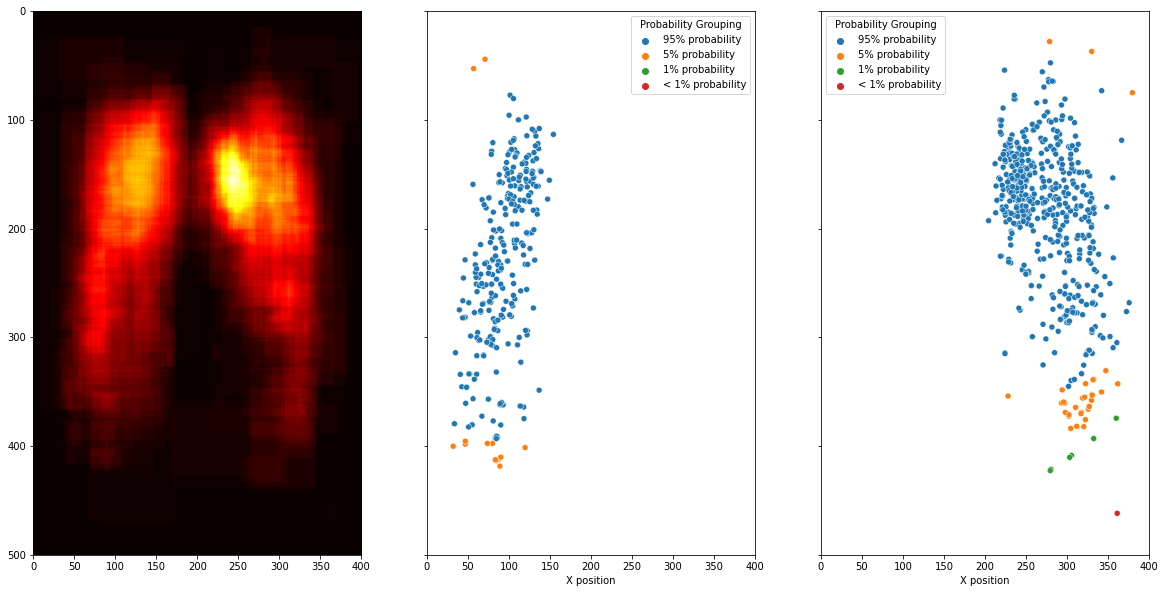

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 2) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 2), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 2) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.3 Cardiomegaly

Similar to Aortic Enlargment, there are certain bounding box centers that exist far outside where we would expect to see them. In this case, groupings that exist in red represent less than a 1% probability of occurring (based on the distribution of bounding box centers in our test data). Again, red and green points are likely going to impact our ability to fit a model accordingly. 

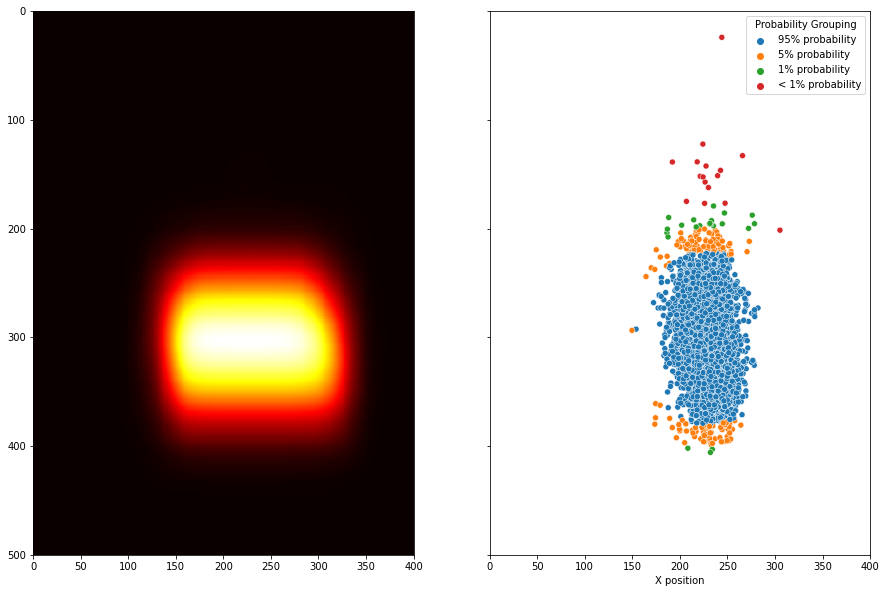

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 3), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.4 Consolidation

Again, we have both the right and left side of the body to consider as separate entities.

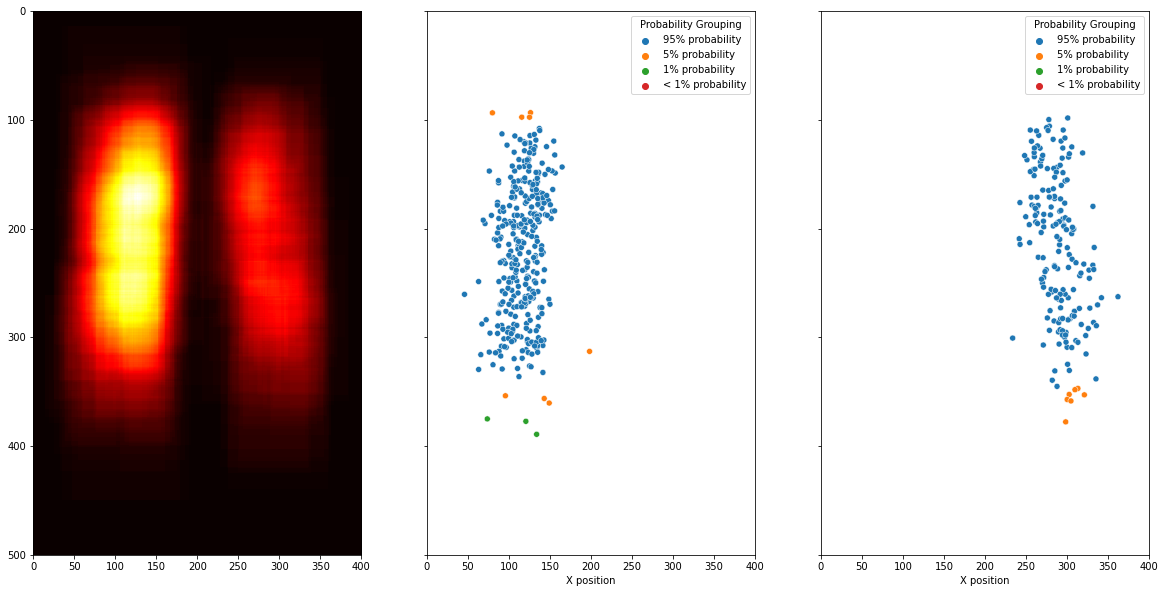

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 4) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 4), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 4) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.5 ILD

Again, we have both the right and left side of the body to consider as separate entities.

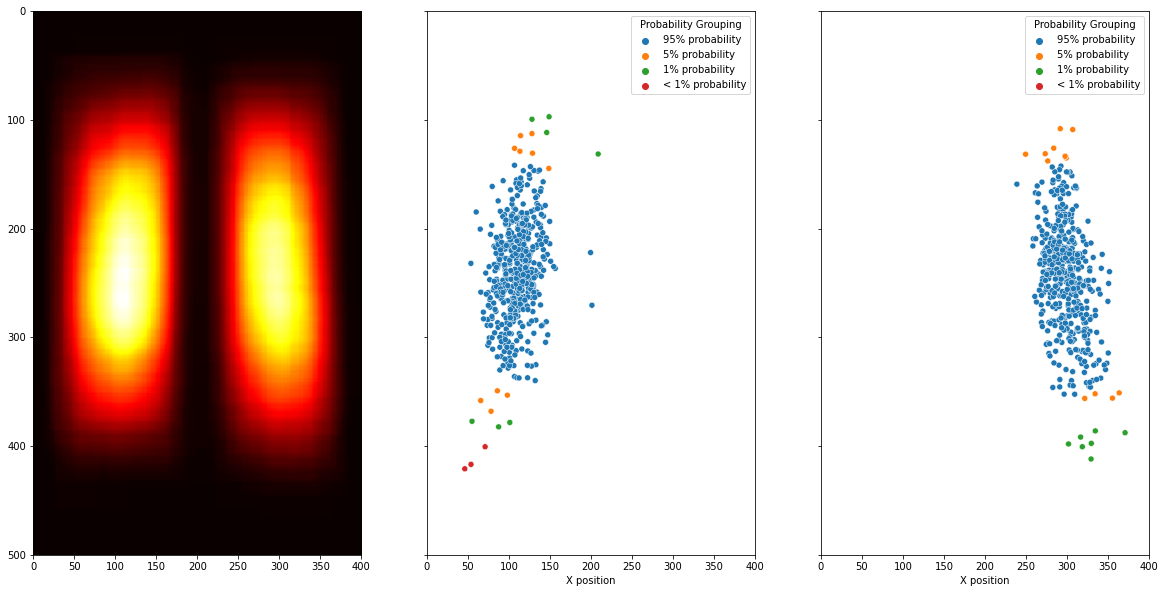

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 5) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 5), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 5) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.6 Infiltration

Again, we have both the right and left side of the body to consider as separate entities.

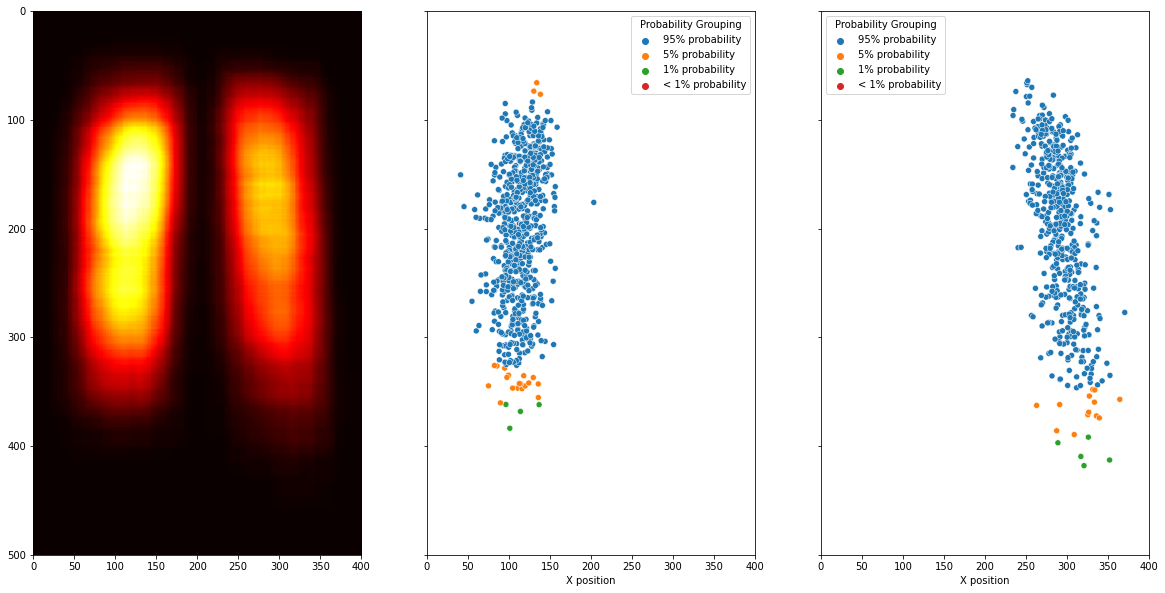

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 6) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 6), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 6) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.7 Lung Opacity

Again, we have both the right and left side of the body to consider as separate entities.

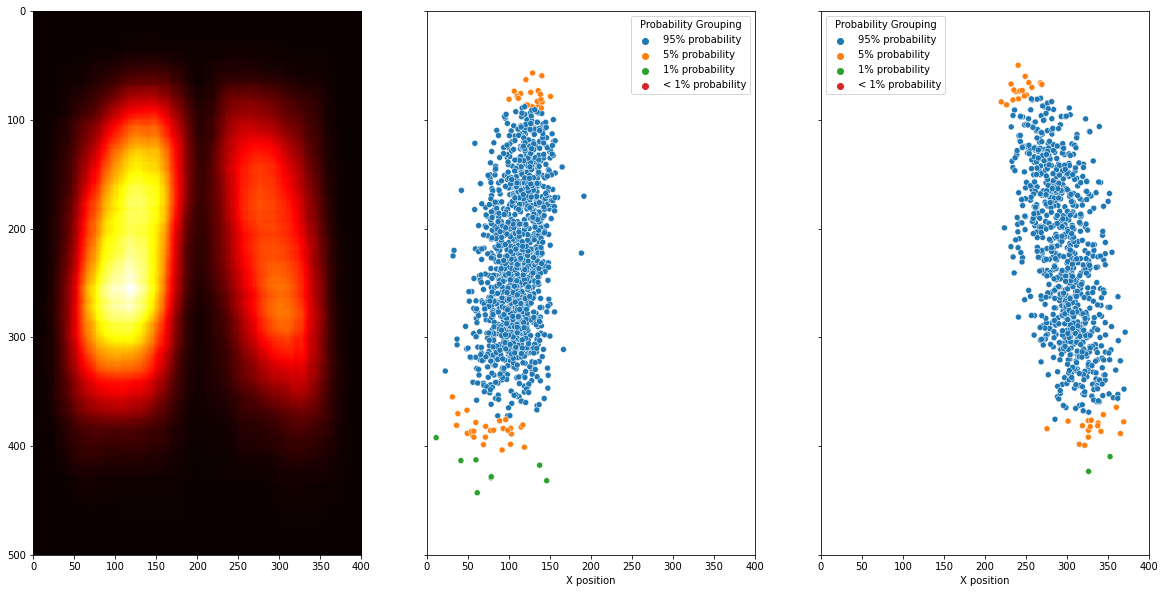

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 7) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 7), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 7) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.8 Nodule / Mass

Again, we have both the right and left side of the body to consider as separate entities.

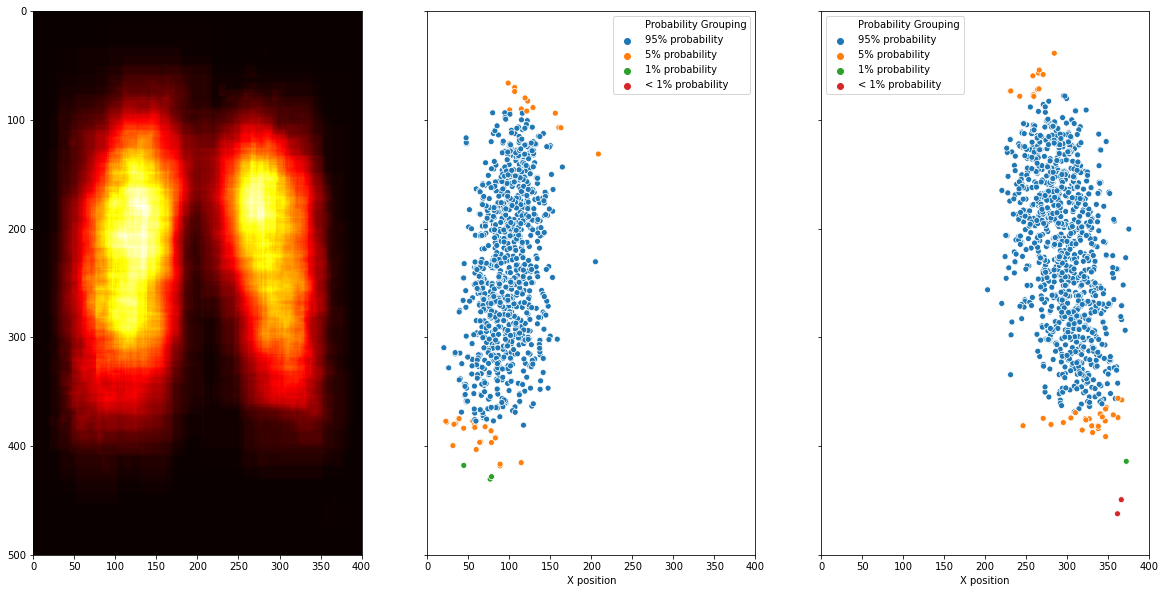

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 8) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 8), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 8) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.9 Other Lesion

Again, we have both the right and left side of the body to consider as separate entities.

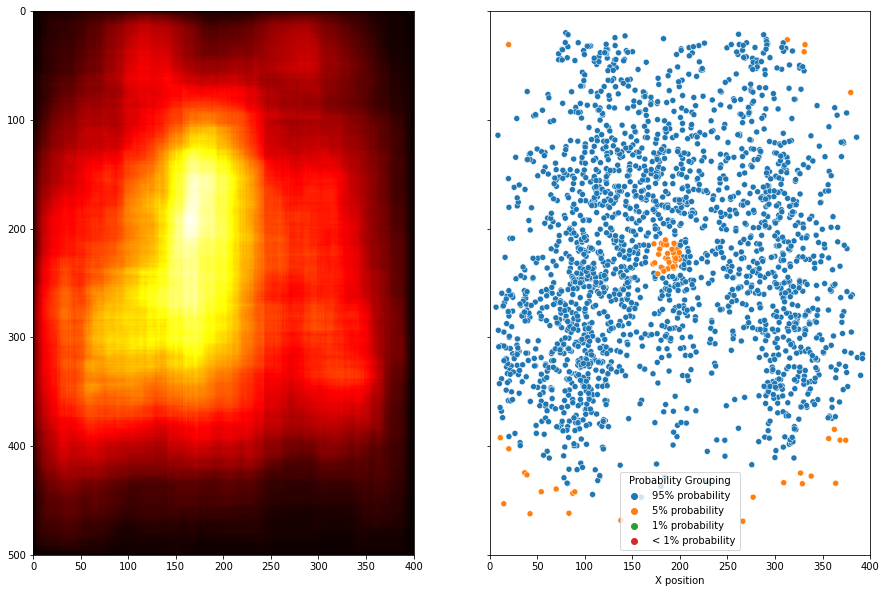

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 9)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 9), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.10 Pleural Effusion

Again, we have both the right and left side of the body to consider as separate entities.

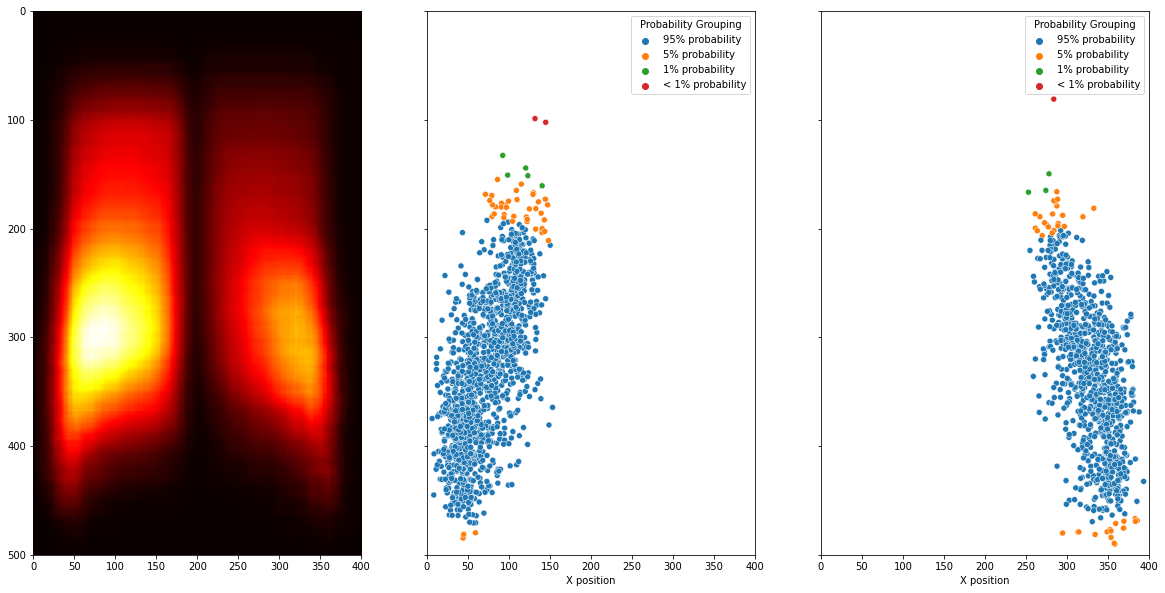

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 10) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 10), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 10) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.11 Pleural Thickening

Again, we have both the right and left side of the body to consider as separate entities. We'll also look to see if we can group them into specific segments using KMeans to search for centroids.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


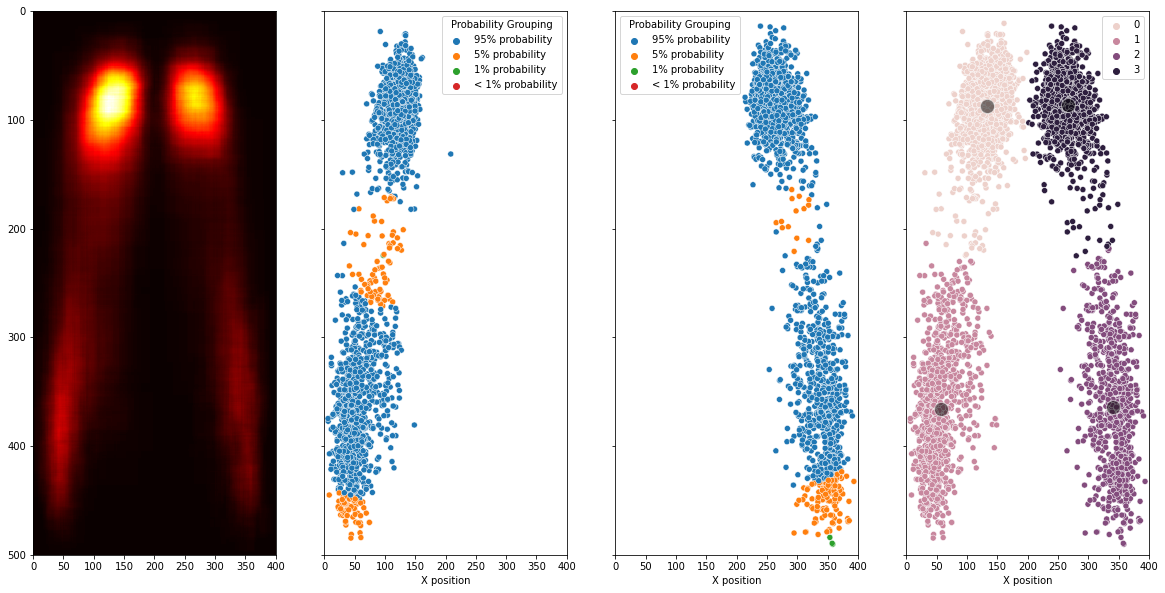

In [24]:
coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 11)])
calculate_centers(coi)
calculate_distances_to_center(coi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 11) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 11), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 11) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 11)])
calculate_centers(coi)
calculate_distances_to_center(coi)
kmeans = KMeans(n_clusters=4)
kmeans.fit(coi[["x_center", "y_center"]])
centroids = kmeans.predict(coi[["x_center", "y_center"]])
centers = kmeans.cluster_centers_

sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=centroids, 
    ax=axs[3],
)
sns.scatterplot(
    centers[:, 0], 
    centers[:, 1], 
    c=['black'], 
    s=200, 
    alpha=0.5, 
    ax=axs[3],
)
_ = axs[3].set(xlabel="X position", ylabel="Y position")
_ = axs[3].set(xlim=(0, 400), ylim=(500, 0))


## 3.3.12 Pnemothorax

Again, we have both the right and left side of the body to consider as separate entities.

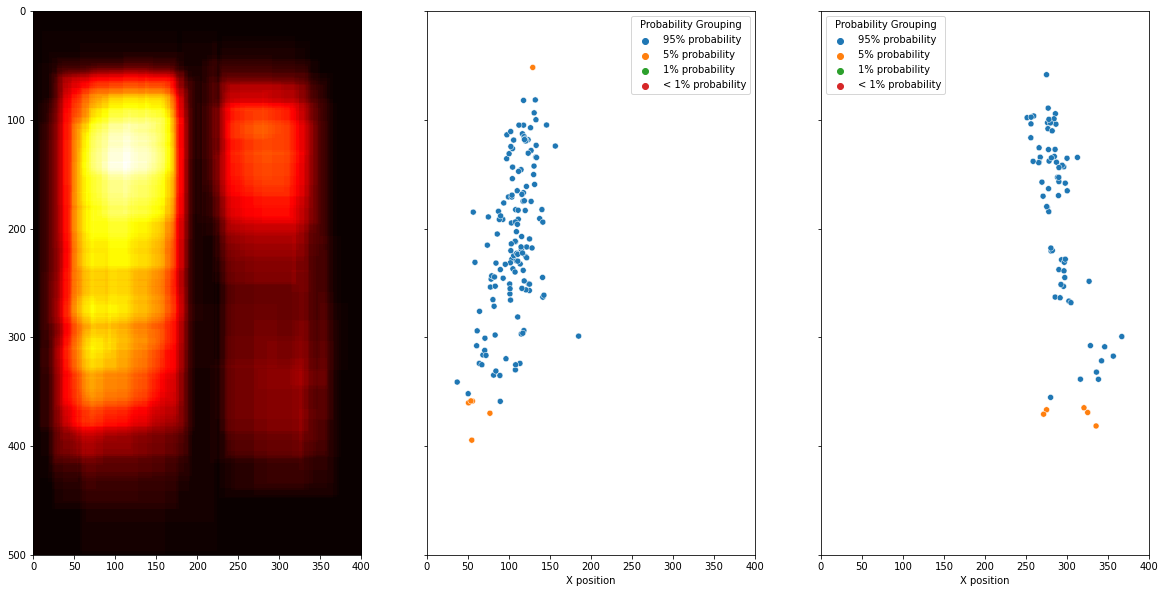

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 12) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 12), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 12) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

## 3.3.13 Pulmonary Fibrosis

Again, we have both the right and left side of the body to consider as separate entities.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


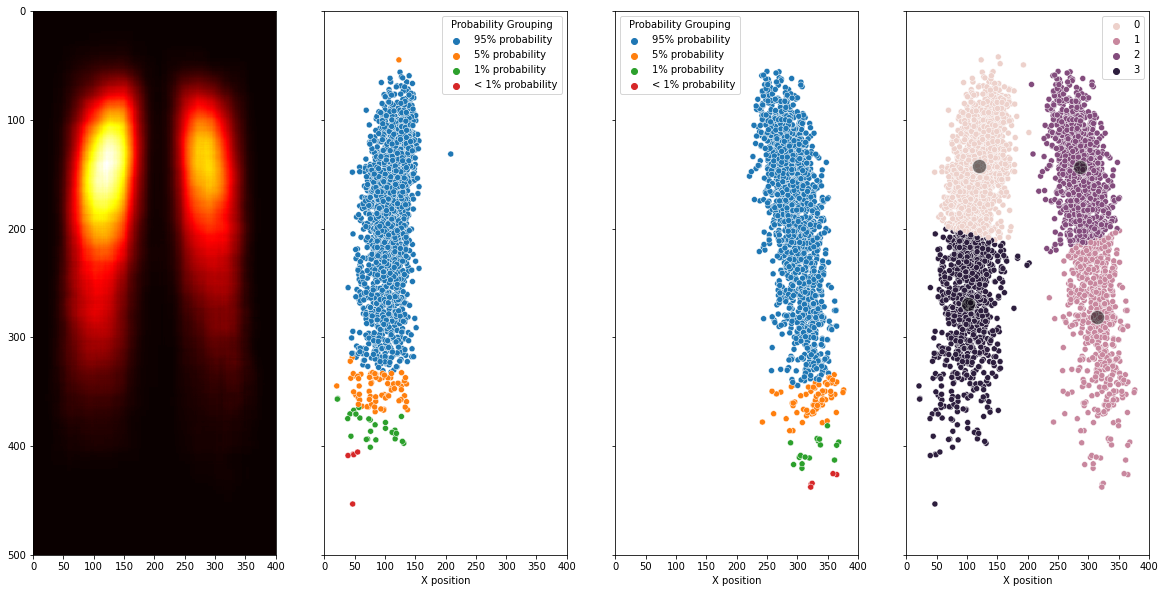

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharey=True)

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 13) & (train_aug["x_min_norm"] < 0.3)])
calculate_centers(coi)
calculate_distances_to_center(coi)
axs[0].imshow(get_bbox(train_aug, 13), cmap='hot', interpolation='nearest', extent=[0,400,500,0], aspect="auto")
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[1]
)
_ = axs[1].set(xlabel="X position", ylabel="Y position")
_ = axs[1].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 13) & (train_aug["x_min_norm"] > 0.5)])
calculate_centers(coi)
calculate_distances_to_center(coi)
sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=coi["Probability Grouping"], 
    hue_order=["95% probability", "5% probability", "1% probability", "< 1% probability"], 
    ax=axs[2]
)
_ = axs[2].set(xlabel="X position", ylabel="Y position")
_ = axs[2].set(xlim=(0, 400), ylim=(500, 0))

coi = pd.DataFrame(train_aug[(train_aug["class_id"] == 13)])
calculate_centers(coi)
calculate_distances_to_center(coi)
kmeans = KMeans(n_clusters=4)
kmeans.fit(coi[["x_center", "y_center"]])
centroids = kmeans.predict(coi[["x_center", "y_center"]])
centers = kmeans.cluster_centers_

sns.scatterplot(
    x="x_center", 
    y="y_center", 
    data=coi[["x_center", "y_center"]], 
    hue=centroids, 
    ax=axs[3],
)
sns.scatterplot(
    centers[:, 0], 
    centers[:, 1], 
    c=['black'], 
    s=200, 
    alpha=0.5, 
    ax=axs[3],
)
_ = axs[3].set(xlabel="X position", ylabel="Y position")
_ = axs[3].set(xlim=(0, 400), ylim=(500, 0))


# 3.4 Discussion

Our heatmaps provide us with some interesting results:

1. The heatmaps can be used to provide a confidence rating for any bounding box that we place. If the box is in a hot zone for a particular clinical finding, we can rate it with a higher degree of confidence. In essence, we would use the heatmap as a confidence prior.
2. The heatmaps are nicely showing us where various clinical findings tend to be localized. We can see for class `0 - Aortic Enlargement` that we expect to see our bounding boxes to appear near the center of the x-ray towards the top of the image. This can help us out greatly. Instead of building a single monolithic classifier, we can build a highly targetted classifier that examines that single area. In essence, we can _zoom in_ on an area as indicated by the heatmap, and focus learning techniques on that specific area instead of the entire image.
3. Localizations tell us that there are generally more findings in the right lung for issues such as `1 - Atelectasis`, `4 - Consolidation`, `7 - Lung Opacity` and `12 - Pneumothorax`. This may be significant possibly due to the differences in lung sizes - the right lung is larger than the left.
4. Based on gender, `12 - Pneumothorax` appears to occur equally on the right and left lung for females. Similarly, `2 - Calcification` appears to occur more frequently on the left lung for females when compared to males. 
5. Certain heatmaps can give us clues how to build additional classifiers. For example, for heatmaps that have symmetrical localizations such as `5 - ILD`, we can very likely build a single classifier that recognizes a single side of the chest (say the right side). Then, we can simply flip the image and see if there is a finding using the same classifier. In this way, we can build single, highly targetted classifiers, but cut down training time (and increase training samples) by using both the left and right hand sides of the images as input sources.

# 4 Aspect Ratios

Another important aspect to consider for the bounding boxes and their localization, is the approximate aspect ratio that each bounding box may take. While we were able to see for some classes already that the aspect ratio reflects only a handful of options (generally 1:1 or 2:1), it would be a good idea to get an idea of how varied aspect ratios actually are on a per-class basis.

The code below will generate an approximate aspect ratio for each of our bounding boxes, and add it to the dataframe.

In [27]:
import math

def get_aspect_ratio(width, height):
    gcd = math.gcd(width, height)
    w_ratio = int(width / gcd)
    h_ratio = int(height / gcd)
    return w_ratio, h_ratio

def get_approximate_aspect_ratio(width, height):
    w_ratio, h_ratio = get_aspect_ratio(width, height)
    while w_ratio > 10:
        w_ratio = round(w_ratio / 10)
        h_ratio = round(h_ratio / 10)
    return get_aspect_ratio(w_ratio, h_ratio)
    
def calculate_aspect_ratio(df):
    ar_width = []
    ar_height = []
    for _, row in df.iterrows():
        if row["class_id"] != 14:
            height = int(row["y_max"] - row["y_min"])
            width = int(row["x_max"] - row["x_min"])
            width_ratio, height_ratio = get_approximate_aspect_ratio(width, height)
            ar_width.append(width_ratio)
            ar_height.append(height_ratio)
        else:
            ar_width.append(1)
            ar_height.append(1)
    df["width_aspect_ratio"] = ar_width
    df["height_aspect_ratio"] = ar_height
    
calculate_aspect_ratio(train_aug)

With the dataframe updated to contain aspect information, we can now add that and plot via a heatmap. The resulting heatmaps will be a plot of _width_ by _height_ that denotes the specific aspect ratio. For example, a width of 4 and a height of 3 indicates a _4:3_ aspect ratio. Intensity will indicate how many findings of that class have a bounding box with that aspect ratio.

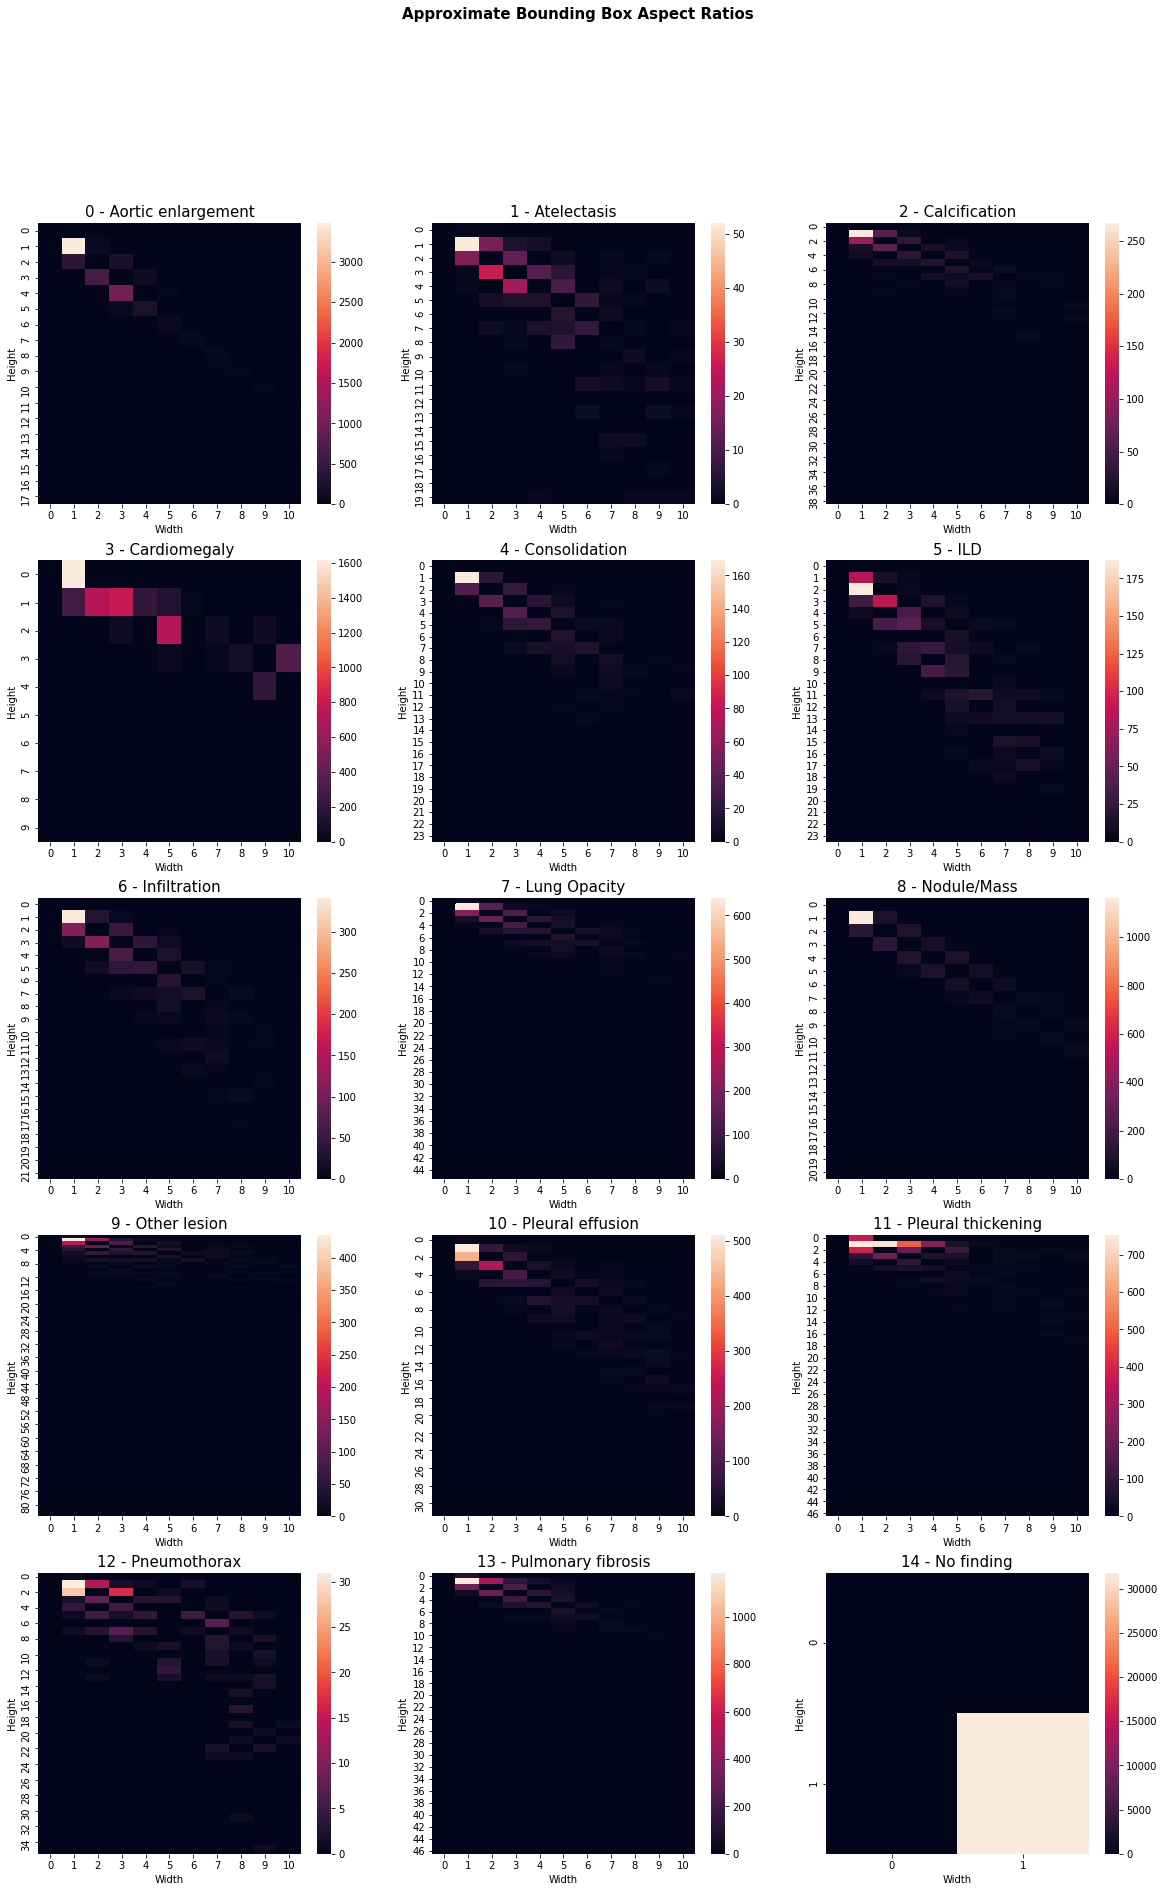

In [28]:
import seaborn as sns

def generate_heatmap_per_class(class_id, df):
    dataframe = df[(df["class_id"] == class_id)]
    heatmap_array = np.zeros(shape=(dataframe["height_aspect_ratio"].max() + 1, dataframe["width_aspect_ratio"].max() + 1))
    for _, row in dataframe.iterrows():
        heatmap_array[row["height_aspect_ratio"], row["width_aspect_ratio"]] += 1
    return heatmap_array

names = [name for name in classes]
heatmaps = [generate_heatmap_per_class(index, train_aug) for index, _ in enumerate(classes)]

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
fig.suptitle("Approximate Bounding Box Aspect Ratios", fontweight="bold", size=15)
for i, (name, heatmap, ax) in enumerate(zip(names, heatmaps, axs.flatten())):
    hm = sns.heatmap(heatmap, annot=False, ax=ax)
    _ = ax.set_xlabel("Width")
    _ = ax.set_ylabel("Height")
    _ = ax.set_title(name, size=15)

# 4.1 Discussion

From our aspect ratios, we can start to see some simple trends:

1. Most classes have a strong affinity towards a _1:1_ aspect ratio. For example `0 - Aortic Enlargement` and `8 - Nodule / Mass` contain bounding boxes with an aspect ratio that are primarily _1:1_ with few other variants occurring.
2. `3 - Cardiomegaly` tend to have bounding boxes that are wider than they are tall.
3. `12 - Pneumothorax` have a wide variety of aspect ratios.
4. `9 - Other lesion` can have any number of conceiveable aspect ratios.

Again, we can use these aspect ratio heatmaps to help us establish a confidence prior to our bounding box regressor. In general, we can look to see if bounding boxes we generate are within an established norm, and help us determine if they need refinement.

# 5. Conclusions

By plotting heatmaps of our bounding boxes, we can easily localize where various findings are expected. We can use heatmap information to establish confidence priors to help with our predictions. Aspect ratio information across classes can help us determine if our predicted bounding boxes make sense, and again can help establish confidence priors.

If you find this visualization useful, please comment or upvote the notebook! Thanks!